In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
# Leitura do arquivo linha por linha
with open('../data/raw/data_set_grupo_b.txt', 'r') as f:
    linhas = f.readlines()

# Conversão para DataFrame
dados_lista = [list(map(float, linha.strip().split())) for linha in linhas]
dados = pd.DataFrame(dados_lista)

# Nomeação das colunas
dados.columns = [f'feature_{i}' for i in range(dados.shape[1]-1)] + ['target']

print("Dimensões do DataFrame:", dados.shape)
print("\nColunas:", dados.columns.tolist())
print("\nPrimeiras linhas:")
print(dados.head())

Dimensões do DataFrame: (130065, 50)

Colunas: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'target']

Primeiras linhas:
     feature_0     feature_1  feature_2  feature_3  feature_4  feature_5  \
0  36499.00000  93565.000000        NaN        NaN        NaN        NaN   
1      2.59413      0.468803    20.6916   0.322648   0.009682   0.374393   
2      3.86388     


Informações das Features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130065 entries, 0 to 130064
Data columns (total 49 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   feature_0   130065 non-null  float64
 1   feature_1   130065 non-null  float64
 2   feature_2   130064 non-null  float64
 3   feature_3   130064 non-null  float64
 4   feature_4   130064 non-null  float64
 5   feature_5   130064 non-null  float64
 6   feature_6   130064 non-null  float64
 7   feature_7   130064 non-null  float64
 8   feature_8   130064 non-null  float64
 9   feature_9   130064 non-null  float64
 10  feature_10  130064 non-null  float64
 11  feature_11  130064 non-null  float64
 12  feature_12  130064 non-null  float64
 13  feature_13  130064 non-null  float64
 14  feature_14  130064 non-null  float64
 15  feature_15  130064 non-null  float64
 16  feature_16  130064 non-null  float64
 17  feature_17  130064 non-null  float64
 18  feature_18  13006

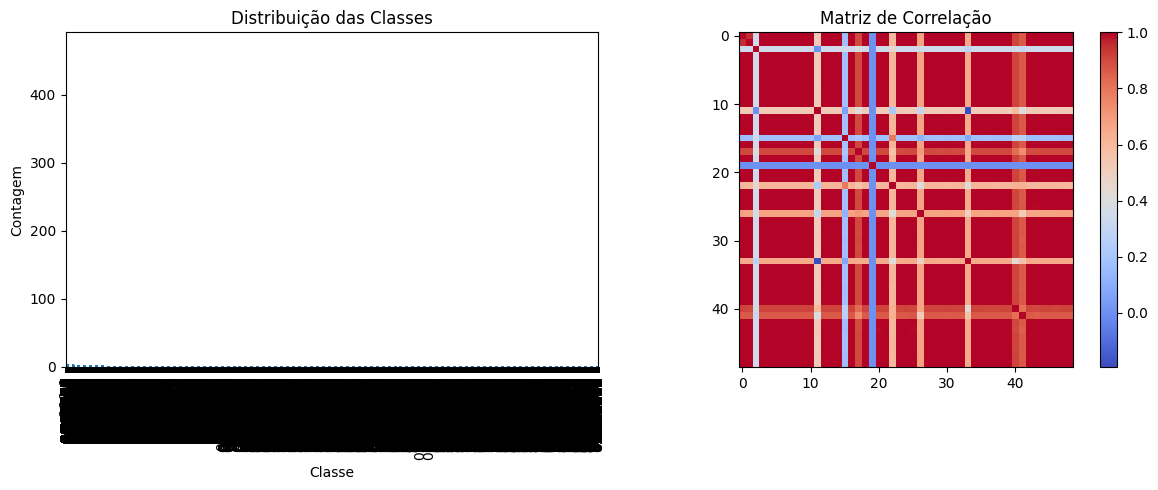

In [3]:
# Separação features/target
X = dados.iloc[:, :-1]
y = dados.iloc[:, -1]

# Estatísticas básicas
print("\nInformações das Features:")
print(X.info())
print("\nEstatísticas descritivas:")
print(X.describe())
print("\nDistribuição das classes:")
print(y.value_counts())

# Visualizações
plt.figure(figsize=(12, 5))

# Distribuição das classes
plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar')
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Contagem')

# Matriz de correlação
plt.subplot(1, 2, 2)
correlacoes = X.corr()
plt.imshow(correlacoes, cmap='coolwarm')
plt.colorbar()
plt.title('Matriz de Correlação')

plt.tight_layout()
plt.show()

In [4]:
# Tratamento de valores ausentes
X = X.fillna(X.mean())

# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Componentes PCA:", pca.n_components_)
print("Variância explicada:", sum(pca.explained_variance_ratio_))

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

Componentes PCA: 5
Variância explicada: 0.9601637985146861


ValueError: Input y contains NaN.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Configuração dos modelos
modelos = {
    'Regressão Logística': {
        'modelo': LogisticRegression(max_iter=1000),
        'params': {'C': [0.1, 1, 10]}
    },
    'Árvore de Decisão': {
        'modelo': DecisionTreeClassifier(),
        'params': {
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Naive Bayes': {
        'modelo': GaussianNB(),
        'params': {}
    }
}

# Treinamento e avaliação
resultados = {}

for nome, config in modelos.items():
    print(f"\nTreinando {nome}...")
    modelo = config['modelo']
    params = config['params']
    
    if params:
        grid = GridSearchCV(modelo, params, cv=5, scoring='f1')
        grid.fit(X_train, y_train)
        modelo = grid.best_estimator_
    else:
        modelo.fit(X_train, y_train)
    
    # Predições
    y_pred = modelo.predict(X_test)
    
    # Métricas
    resultados[nome] = {
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    }

In [ ]:
# DataFrame com resultados
df_resultados = pd.DataFrame(resultados).T
print("\nResultados dos Modelos:")
print(df_resultados)

# Visualização das métricas
plt.figure(figsize=(12, 6))
df_resultados.plot(kind='bar')
plt.title('Comparação de Métricas entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Salvando resultados
df_resultados.to_csv('../data/processed/resultados_classificacao_b.csv')